<a href="https://colab.research.google.com/github/fernandofsilva/thesis/blob/main/Pr%C3%A9_processamento_dos_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#@title Carregar as bibliotecas bases
import pandas as pd
import numpy as np
import math

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

Os dados desse trabalho foram retirados diretamente do [site da B3](http://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/mercado-a-vista/cotacoes-historicas/), a B3 disponibiliza os arquivos por ano com as cotações diárias de todos ativos negociados por ela.

O arquivo Csv carregado na próxima célula já foi processado utilizando o pacote [Bovespa](https://github.com/fernandofsilva/bovespa), a versão do link é uma versão modificada por mim, o pacote original é antigo e possui alguns erros e rótulos desatualizados, se você quiser acessar a versão original do pacote esse é o [link](https://pypi.org/project/bovespa/).

In [ ]:
#@title Carregando os dados de cotações da B3 com o periódo de 2015 até 2020.
raw_data = pd.read_csv('/content/drive/My Drive/Datasets/cotacao.csv.gz')
raw_data.head()

,TIPREG,DATPRG,CODBDI,CODNEG,TPMERC,NOMRES,ESPECI,PRAZOT,MODREF,PREABE,PREMAX,PREMIN,PREMED,PREULT,PREOFC,PREOFV,TOTNEG,QUATOT,VOLTOT,PREEXE,INDOPC,DATVEN,FATCOT,PTOEXE,CODISI,DISMES
0,1,2015-01-02,2,AAPL34,10,APPLE,DRN,NaN,R$,29.65,29.65,29.45,29.61,29.45,29.20,0.00,2,32300,9.564350e+05,0.0,0,9999-12-31,1,0,BRAAPLBDR004,111
1,1,2015-01-02,2,ABCB4,10,ABC BRASIL,PN EJS N2,NaN,R$,12.85,12.85,12.35,12.54,12.55,12.55,12.56,531,117100,1.469337e+06,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
2,1,2015-01-02,96,ABCB4F,20,ABC BRASIL,PN EJS N2,NaN,R$,12.83,12.83,12.48,12.69,12.48,12.53,12.86,5,208,2.641260e+03,0.0,0,9999-12-31,1,0,BRABCBACNPR4,123
3,1,2015-01-02,12,ABCP11,10,FII ABC IMOB,CI ER,NaN,R$,9.72,9.72,8.01,9.64,9.64,9.31,9.64,9,496,4.781490e+03,0.0,0,9999-12-31,1,0,BRABCPCTF000,231
4,1,2015-01-02,2,ABEV3,10,AMBEV S/A,ON EJ,NaN,R$,16.14,16.56,15.77,16.08,16.01,15.91,16.01,21543,19110800,3.073420e+08,0.0,0,9999-12-31,1,0,BRABEVACNOR1,106


# PETR4

O foco desse trabalho é utilizando o ativo PETR4 e as opções do ativo subjacente.

In [ ]:
#@title Filtrando o dataset e selecionando apenas o ativo PETR4
# Filter data
spot = raw_data[raw_data['CODNEG'] == 'PETR4']

# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'PREULT': 'S'
}

# Rename the columns and subset
spot = spot.rename(columns=dict_ref)
spot = spot[dict_ref.values()]

# Format and subset date
spot['date'] = pd.to_datetime(spot['date'])
spot = spot.sort_values(by='date')
spot.index = spot['date']
spot = spot.drop(['date'], axis=1)

spot.head()

,S
date,
2015-01-02,9.36
2015-01-05,8.61
2015-01-06,8.33
2015-01-07,8.67
2015-01-08,9.18


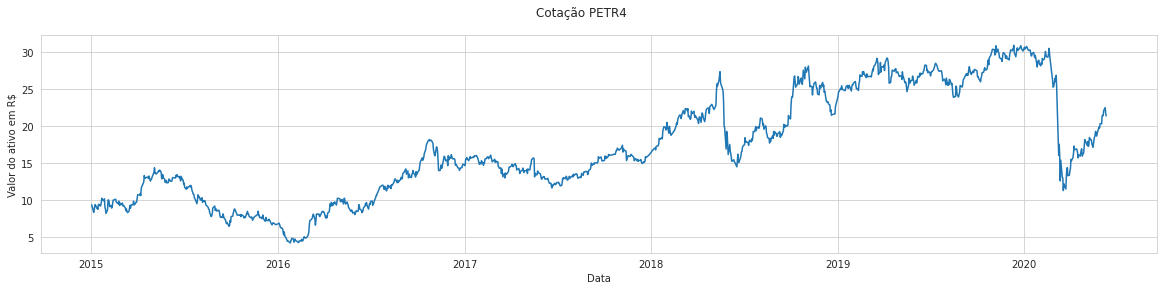

In [ ]:
#@title Plot com os dados selecionados
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Cotação PETR4')
ax.plot(spot['S'])
ax.set_ylabel('Valor do ativo em R$')
ax.set_xlabel('Data')
plt.show()

# Opções

Selecionada somente os dados de opções e ajustados os rótulos de acordo com [guia](http://www.b3.com.br/data/files/33/67/B9/50/D84057102C784E47AC094EA8/SeriesHistoricas_Layout.pdf) fornecido pela B3.

In [ ]:
#@title Processamento dos dados de opções
# Dict to rename the columns
dict_ref = {
    'DATPRG': 'date',
    'CODNEG': 'option',
    'PREULT': 'value',
    'PREEXE': 'X',
    'DATVEN': 'expire',
    'TPMERC': 'option_type'
}

# Rename the columns
option = raw_data.rename(columns=dict_ref)

# Filter options data
option = option[option['option_type'].isin([70, 80])]
option = option[option['option'].str.startswith('PETR')]
option = option[dict_ref.values()]

# Dict symbol type
TPMERC = {70: 'call', 80: 'put'}

# Replace options types
option['option_type'] = option['option_type'].replace(TPMERC)
option.head()

,date,option,value,X,expire,option_type
915,2015-01-02,PETRA1,0.13,10.66,2015-01-19,call
916,2015-01-02,PETRA10,1.00,8.61,2015-01-19,call
917,2015-01-02,PETRA11,0.02,21.00,2015-01-19,call
918,2015-01-02,PETRA12,0.02,12.91,2015-01-19,call
919,2015-01-02,PETRA13,0.01,13.91,2015-01-19,call


A variável T  é dada pelo fração do tempo em formato anual, entre o dia da cotação até o vencimento da opção.

In [ ]:
#@title Cálculo da variável T
# Get unique days
workday = pd.DataFrame({'day': option['date'].unique()})
workday['day'] = pd.to_datetime(workday['day'])
workday = workday.sort_values(by='day')

# Create T
T = list()

for index, row in option.iterrows():
    T.append(workday[(workday['day'] >= row.date) & (workday['day'] <= row.expire)].shape[0] - 1)

option['T'] = T
option['T'] = option['T'] / 252

# Format and subset date
option['date'] = pd.to_datetime(option['date'])
option['expire'] = pd.to_datetime(option['expire'])
option = option.sort_values(by='date')

# Set index
option.index = option['date']
option = option.drop(['date'], axis=1)

option.head()

,option,value,X,expire,option_type,T
date,,,,,,
2015-01-02,PETRA1,0.13,10.66,2015-01-19,call,0.043651
2015-01-02,PETRL44,0.50,17.00,2015-12-21,call,0.952381
2015-01-02,PETRM1,1.34,10.66,2015-01-19,put,0.043651
2015-01-02,PETRM10,0.19,8.61,2015-01-19,put,0.043651
2015-01-02,PETRM12,3.58,12.91,2015-01-19,put,0.043651


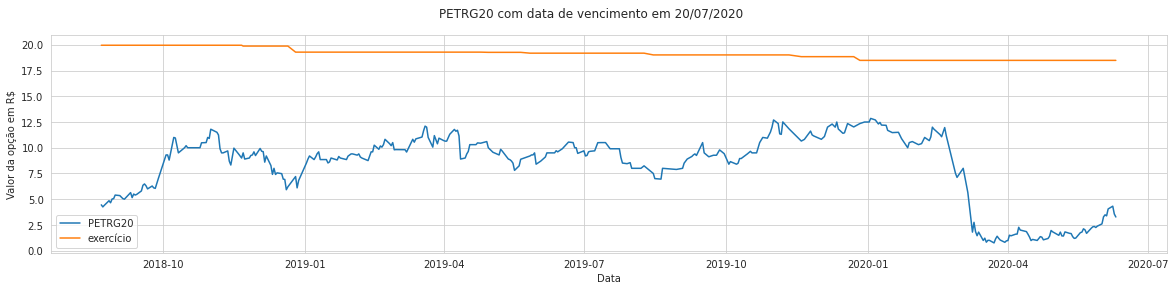

In [ ]:
#@title Plot dos dados da opção PETRG20
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('PETRG20 com data de vencimento em 20/07/2020')
ax.plot(option.loc[(option['option'] == 'PETRG20') & (option['expire'] == '2020-07-20'), 'value'], label='PETRG20')
ax.plot(option.loc[(option['option'] == 'PETRG20') & (option['expire'] == '2020-07-20'), 'X'], label='exercício')
ax.set_ylabel('Valor da opção em R$')
ax.set_xlabel('Data')
ax.legend()
plt.show()

# CDI

Os dados do CDI são retirados diretamente do [Banco Central](https://www.bcb.gov.br/htms/SELIC/SELICdiarios.asp?frame=1), nesse trabalho utilizamos o valor de taxa básica de juros livre de risco (cupom limpo, significa que é utilizada da taxa de último dia do mês, isso porque durante o mês a taxa pode ser negativa)

In [ ]:
#@title Dados de CDI do Banco Central
cdi = pd.read_csv('/content/drive/My Drive/Datasets/cdi.csv', usecols=['date', 'cdi'])

In [ ]:
#@title Format CDI Data
# Format and subset date
cdi['date'] = pd.to_datetime(cdi['date'], format='%d/%m/%y')
cdi = cdi.sort_values(by='date')

# Filter using the first date
cdi = cdi[cdi['date'].dt.month != cdi['date'].dt.month.shift(1)]

# Create date range
date = pd.DataFrame({'date': pd.date_range(start='1/1/2015', end='12/31/2020')})

# Merge with cdi
date = date.merge(right=cdi, how='left', on='date')

# Fill Nan
date['cdi'] = date['cdi'].fillna(method='ffill')
cdi = date.dropna()

# Create index
cdi = cdi.rename(columns={'cdi': 'r'})
cdi.index = cdi['date']
cdi = cdi.drop(['date'], axis=1)
cdi.head()

,r
date,
2015-01-02,11.57
2015-01-03,11.57
2015-01-04,11.57
2015-01-05,11.57
2015-01-06,11.57


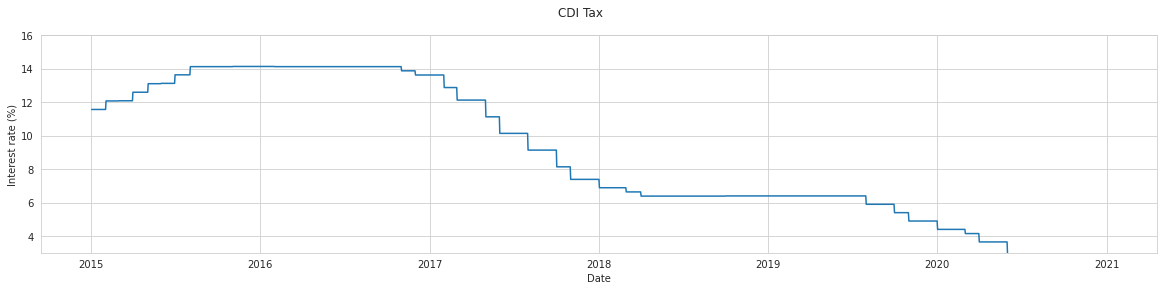

In [ ]:
#@title Plot CDI Data
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('CDI Tax')
ax.plot(cdi)
ax.set_ylabel('Interest rate (%)')
ax.set_ylim(3, 16)
ax.set_xlabel('Date')
plt.show()

# GARCH (1,1)

Para o cálculo do valor da opção, também necessário estimar o valor da volitilidade no período, a volitilidade é estimada a partir dos retornos do ativo, dado pela fórmula $\ln\left(\dfrac{S_{i}}{S_{i-1}}\right)$ onde $S$ é o valor do ativo e $i$ o dia.

In [ ]:
#@title Cálculo de retornos PETR4
spot['return'] = np.log(spot['S'] / spot['S'].shift(1))
spot = spot.dropna()
spot.head()

,S,return
date,,
2015-01-05,8.61,-0.083521
2015-01-06,8.33,-0.033061
2015-01-07,8.67,0.040005
2015-01-08,9.18,0.057158
2015-01-09,9.40,0.023682


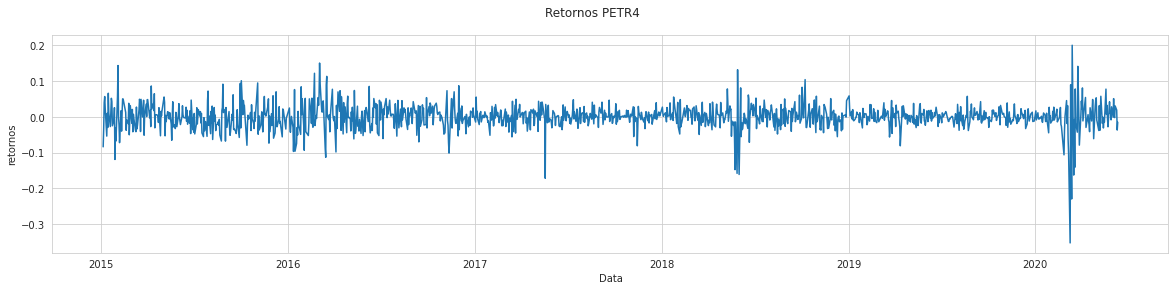

In [ ]:
#@title Plot dos retornos de PETR4
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('Retornos PETR4')
ax.plot(spot['return'])
ax.set_ylabel('retornos')
ax.set_xlabel('Data')
plt.show()

In [ ]:
#@title instalação do pacote arch para modelagem da volatilidade
!pip install arch

In [ ]:
#@title Modelagem de volitidade por Garch(1,1)
from arch import arch_model

am = arch_model(spot['return'], p=1, o=0, q=1)
res = am.fit(update_freq=5)
garch = res.conditional_volatility * math.sqrt(252) * 100
garch = garch.rename("sigma")
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2818.1945447644266
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                2818.19
Distribution:                  Normal   AIC:                          -5628.39
Method:            Maximum Likelihood   BIC:                          -5607.58
                                        No. Observations:                 1343
Date:                Fri, Nov 06 2020   Df Residuals:                     1339
Time:                        00:45:08   Df Model:                            4
                                  Mean Model                                 
 

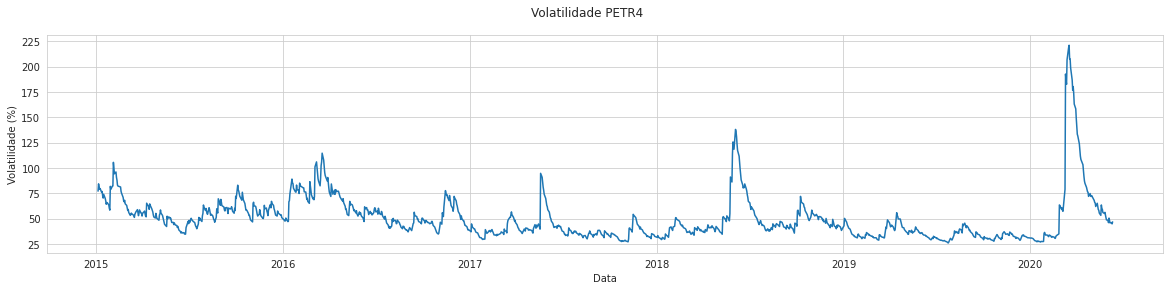

In [ ]:
#@title Plot Volatilidade
fig, axs = plt.subplots(figsize=(20, 4))
fig.suptitle('Volatilidade PETR4')
axs.plot(garch)
axs.set_ylabel('Volatilidade (%)')
axs.set_xlabel('Data')
plt.show()

# Junção dos dados

In [ ]:
#@title Junção entre as bases PETR4, Opções, CDI e GARCH
data = option.merge(right=spot, right_index=True, left_index=True)
data = data.merge(right=cdi, right_index=True, left_index=True)
data = data.merge(right=garch, right_index=True, left_index=True)
data = data.rename(columns={'cond_vol': 'vol'})
data.head()

,option,value,X,expire,option_type,T,S,return,r,sigma
date,,,,,,,,,,
2015-01-05,PETRM2,0.02,4.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396
2015-01-05,PETRM23,0.79,9.21,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396
2015-01-05,PETRM25,1.13,9.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396
2015-01-05,PETRM51,0.15,7.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396
2015-01-05,PETRM16,7.13,15.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396


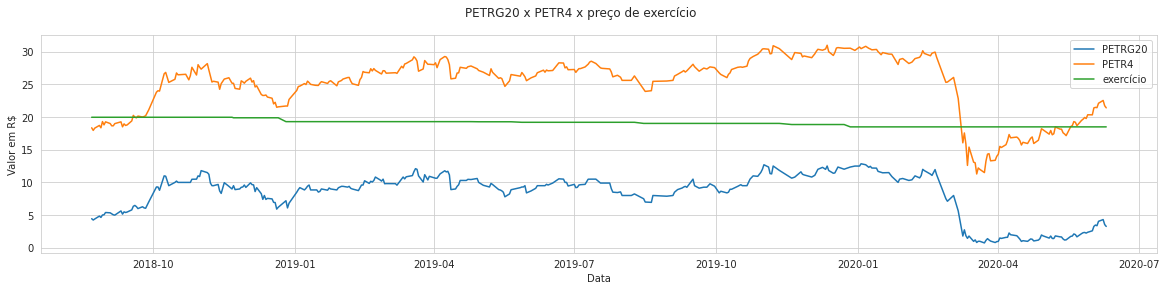

In [ ]:
#@title Plot dos dados juntos
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('PETRG20 x PETR4 x preço de exercício')
ax.plot(data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'value'], label='PETRG20')
ax.plot(data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'S'], label='PETR4')
ax.plot(data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'X'], label='exercício')
ax.set_ylabel('Valor em R$')
ax.set_xlabel('Data')
ax.legend()
plt.show()

# Black-Scholes

O cálculo fórmula de Black-Scholes de uma opção de compra é dado pela equação $C(t, T) = S(t)N(d_{1}) - Ke^{-r(T-t))}N(d_{2})$ e venda $P(t, T) = Ke^{-r(T-t))}N(-d_{2}) - S(t)N(-d_{1})$, onde $d_{1} = \frac{\ln\bigg({\frac{S(t)}{K}}\bigg)+\bigg(r+\frac{\sigma^{2}}{2}\bigg)(T-t)}{\sigma\sqrt{T-t}}$ e $d_{2} = \frac{\ln\bigg({\frac{S(t)}{K}}\bigg)+\bigg(r-\frac{\sigma^{2}}{2}\bigg)(T-t)}{\sigma\sqrt{T-t}}$.

In [ ]:
#@title Formula
from scipy.stats import norm

# Auxiliary function for d_one risk-adjusted probability
def d11(S, X, T, r, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

# Auxiliary function for d_two risk-adjusted probability
def d21(d1, T, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return d1 - sigma * np.sqrt(T)

# Definition of the Black-Scholes delta function
def bs_delta(S, X, T, r, sigma, option_type):
    """Compute the delta of the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the delta value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    if option_type == 'call':
        return norm.cdf(d11(S, X, T, r, sigma))
    elif option_type == 'put':
        return norm.cdf(-d11(S, X, T, r, sigma))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

# Definition of the Black-Scholes European option pricing formula
def black_scholes(S, X, T, r, sigma, option_type):
    """Price a European option using the Black-Scholes option pricing formula.

    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'

    Returns: a numpy.float_ representing the option value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    d_one = d11(S, X, T, r, sigma)
    d_two = d21(d_one, T, sigma)
    if option_type == 'call':
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'put':
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

def bs_pandas(row):
    value = black_scholes(
        row['S'], row['X'], row['T'], row['r']/100, row['sigma']/100, row['option_type']
    )
    return round(value, 2)

def delta_pandas(row):
    value = bs_delta(
        row['S'], row['X'], row['T'], row['r']/100, row['sigma']/100, row['option_type']
    )
    return int(round(value * 100, 0))

data['bs'] = data.apply(bs_pandas, axis=1)
data['delta_bs'] = data.apply(delta_pandas, axis=1)
data.head()

,option,value,X,expire,option_type,T,S,return,r,sigma,bs,delta_bs
date,,,,,,,,,,,,
2015-01-05,PETRM2,0.02,4.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.00,0
2015-01-05,PETRM23,0.79,9.21,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.87,63
2015-01-05,PETRM25,1.13,9.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,1.16,73
2015-01-05,PETRM51,0.15,7.61,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,0.14,18
2015-01-05,PETRM16,7.13,15.91,2015-01-19,put,0.039683,8.61,-0.083521,11.57,77.210396,7.23,100


Essa fase é necessária para o input dos dados na rede LSTM, redes LTSM precisam dos dados em 3 dimensões, porém não existe uma quantidade fixa de dias de negócios para cada opção, para fixar um valor de time steps, foram criados dias em branco com valores 0 para inserir dentro da rede, esses valores não prejudicam o treinamento, uma vez que não existem opções de valores 0.

In [ ]:
#@title Padding com time steps de 500 dias

# Reset index
data = data.reset_index()

# Create reference dataframe
reference = data.groupby(['expire', 'option', 'option_type'], as_index=False).agg({'X': 'count'})
reference = reference.drop(['X'], axis=1)

# Create empty dataframe to append data
df = pd.DataFrame()

# Loop over the reference dict
for index, row in reference.iterrows():

    # Filter the data according the options
    subset = data[(data['expire'] == row['expire']) & (data['option'] == row['option'])]

    # Calcule the size of the data
    size = 500 - subset.shape[0]

    if size > 0:
        # Create padding data
        subset = pd.DataFrame({'date': pd.date_range(start='1/1/2010', periods=size),
                    'option': [row['option']] * size,
                    'value': [0] * size,
                    'X': [0] * size,
                    'expire': [row['expire']] * size,
                    'option_type': [row['option_type']] * size,
                    'T': [0] * size,
                    'S': [0] * size,
                    'return': [0] * size,
                    'r': [0] * size,
                    'sigma': [0] * size,
                    'bs': [0] * size,
                    'delta_bs': [0] * size
        }).append(subset)
    else:
        subset = subset[-50:]

    # Append in the dataframe
    df = df.append(subset)

# Assign to data variable
data = df
del df

# Order data
data = data.sort_values(by=['expire', 'option', 'date'])
data = data.reset_index()
data = data.drop(['index'], axis=1)
data.head()

,date,option,value,X,expire,option_type,T,S,return,r,sigma,bs,delta_bs
0,2010-01-01,PETRA1,0.0,0.0,2015-01-19,call,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2010-01-02,PETRA1,0.0,0.0,2015-01-19,call,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2010-01-03,PETRA1,0.0,0.0,2015-01-19,call,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2010-01-04,PETRA1,0.0,0.0,2015-01-19,call,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2010-01-05,PETRA1,0.0,0.0,2015-01-19,call,0.0,0.0,0.0,0.0,0.0,0.0,0


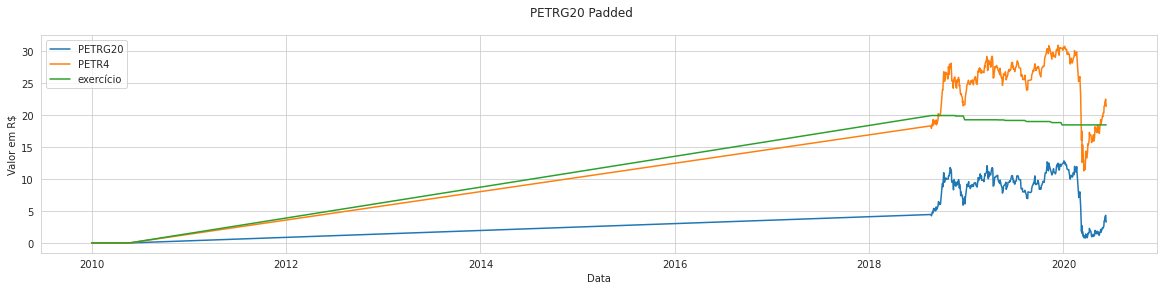

In [ ]:
#@title Plot PETRG20 Padded
# Plot
fig, ax = plt.subplots(figsize=(20, 4))
fig.suptitle('PETRG20 Padded')
ax.plot(
    data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'date'],
    data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'value'], label='PETRG20'
)
ax.plot(
    data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'date'],
    data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'S'],
    label='PETR4'
)
ax.plot(data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'date'],
        data.loc[(data['option'] == 'PETRG20') & (data['expire'] == '2020-07-20'), 'X'],
        label='exercício'
)
ax.set_ylabel('Valor em R$')
ax.set_xlabel('Data')
ax.legend()
plt.show()

# Dividindo os dados entre treino, teste e validação

O periodo dos dados é composto de janeiro de 2015 até março de 2020. Assim, os dados de treino e teste pertencem ao periodo de janeiro de 2015 até dezembro de 2019, com uma divisão de 70% treino e 30% teste e os dados de validação pertecem ao periodo de janeiro de 2020 até março de 2020.

Para a divisão entre treino e teste, foi utilizada a seguinte métodologia:

- Os dados foram divididos considerando a data de vencimento da opção
- Após selecionada as opções dentro do mesmo vencimento, a divisão entre treino e teste foi feito da maneira aleatória, considerando a divisão 70/30.

In [ ]:
#@title Treino, teste e validação
# Define validation data
val = data[data['expire'] > '2020-01-01']
data = data[data['expire'] < '2020-01-01']

# Define train size dataframe percentage
train_size = .70

# Get list with unique expire date
expire_list = data['expire'].sort_values().unique()

# Create stratify column
data['stratify'] = ''

# Loop over the expire list 
for date in expire_list:

    # Get options from expire date
    option_list = data.loc[data['expire'] == date, 'option'].unique()

    # Calculate the size of ta
    size = int(option_list.shape[0] * train_size)

    # Generate random list of integers
    random_list = np.random.choice(range(option_list.shape[0]), size, replace=False)

    # Subset options randomly between train and test
    option_train = option_list[random_list]
    option_test = np.delete(option_list, random_list, None)

    data.loc[(data['expire'] == date) & (data['option'].isin(option_train)), 'stratify'] = 'train'
    data.loc[(data['expire'] == date) & (data['option'].isin(option_test)), 'stratify'] = 'test'

train = data[data['stratify'] == 'train']
test = data[data['stratify'] == 'test']

# Save to file

In [ ]:
#@title Salvar arquivo processado
# Save file to Csv
cols = ['date', 'option', 'value', 'X', 'expire', 'option_type', 'T', 'S',
       'return', 'r', 'sigma', 'bs', 'delta_bs']

data[cols].to_csv(f'/content/drive/My Drive/Datasets/data_option.csv.gz', index=False, compression='gzip')
train[cols].to_csv(f'/content/drive/My Drive/Datasets/train_option.csv.gz', index=False, compression='gzip')
test[cols].to_csv(f'/content/drive/My Drive/Datasets/test_option.csv.gz', index=False, compression='gzip')
val[cols].to_csv(f'/content/drive/My Drive/Datasets/val_option.csv.gz', index=False, compression='gzip')